In [30]:
import pandas as pd
from datetime import timedelta
import json
import os

def input_timings(num_questions):
    timings = []
    print("Enter the timings (HH:MM:SS) taken for each question starting from the total time (e.g., 01:15:00):")
    for i in range(num_questions):
        time_str = input(f"Time remaining after question {i+1} (HH:MM:SS): ")
        print(time_str)
        if len(time_str.split(':')) == 2:
            h = 0
            m, s = map(int, time_str.split(':'))
        elif len(time_str.split(':')) == 1:
            h, s = 0, 0
            m = int(time_str)
        else:
            h, m, s = map(int, time_str.split(':'))
        time_remaining = timedelta(hours=h, minutes=m, seconds=s)
        timings.append(time_remaining)

        if time_remaining.total_seconds() == 0:
            # add the rest of the questions with 0 time
            timings.extend(timedelta(seconds=0) for _ in range(i+1, num_questions))
            break
        
    return timings

def analyze_timings(timings, total_time):
    total_time_delta = timedelta(minutes=int(total_time))
    data = {
        'Question': list(range(1, len(timings) + 1)),
        'Time Remaining': timings,
        'Time Spent': [total_time_delta - t for t in timings]
    }
    df = pd.DataFrame(data)
    df['Time Spent on Question'] = df['Time Spent'].diff().fillna(df['Time Spent'][0])
    return df

def format_timedelta(td):
    total_seconds = int(td.total_seconds())
    hours, remainder = divmod(total_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{hours:02}:{minutes:02}:{seconds:02}"

paper_name = input("Enter the name of the paper: ")
total_time = input("Enter the total time available for the paper (in minutes): ")  # total time for the paper in minutes
num_questions = int(input("Enter the number of questions: "))

# Step 3: Input timings for each question
timings = input_timings(num_questions)

# Step 4: Analyze the timings
analysis_df = analyze_timings(timings, total_time)

# Step 5: Check for extra time and distribute it
last_time_remaining = analysis_df['Time Remaining'].iloc[-1]
extra_time = last_time_remaining.total_seconds() / 60  # in minutes

if extra_time > 0:
    print(f"\nYou have {extra_time:.2f} minutes extra time remaining.")
    while extra_time > 0:
        question_number = int(input("Enter the question number you want to add time to: "))
        if question_number == 0:
            break
        add_time = float(input("Enter the amount of time (in minutes) to add to this question: "))
        if add_time <= extra_time:
            extra_time -= add_time
            analysis_df.at[question_number - 1, 'Time Spent on Question'] = format_timedelta(
                timedelta(minutes=(timedelta(minutes=float(analysis_df.at[question_number - 1, 'Time Spent on Question'].split(':')[0])).total_seconds() / 60) + add_time)
            )
            print(f"Added {add_time:.2f} minutes to question {question_number}. Remaining extra time: {extra_time:.2f} minutes.")
        else:
            print(f"Cannot add {add_time:.2f} minutes because it exceeds the remaining extra time of {extra_time:.2f} minutes.")
else:
    print("No extra time left after the last question.")

# Step 6: Format the timedelta columns for better readability
analysis_df['Time Remaining'] = analysis_df['Time Remaining'].apply(format_timedelta)
analysis_df['Time Spent'] = analysis_df['Time Spent'].apply(format_timedelta)
analysis_df['Time Spent on Question'] = analysis_df['Time Spent on Question'].apply(format_timedelta)

# Display the analysis
print("\nTime Analysis:")
print(analysis_df.to_string(index=False))

# Convert the DataFrame to a dictionary
analysis_dict = analysis_df.to_dict(orient='list')
# Add the paper name to the dictionary
analysis_dict['Paper Name'] = paper_name
analysis_dict['Total Time'] = total_time

# Read the existing data from the JSON file if it exists
file_path = 'time_analysis.json'
if os.path.exists(file_path):
    with open(file_path, 'r') as json_file:
        papers_list = json.load(json_file)
else:
    papers_list = []

# Append the new paper analysis to the list
papers_list.append(analysis_dict)

# Write the updated list to the JSON file
with open(file_path, 'w') as json_file:
    json.dump(papers_list, json_file, indent=4)

print(f"\nTime analysis has been saved to '{file_path}'")


Enter the timings (HH:MM:SS) taken for each question starting from the total time (e.g., 01:15:00):
1:11:23
1:09:00
1:02:30
57:30
51:45
48:15
43:50
38:30
33:20
22:00
18:05
15:50
12:30
2:30
2:15
2:10
2:0
1:45
1:30
1:05

You have 1.08 minutes extra time remaining.

Time Analysis:
 Question Time Remaining Time Spent Time Spent on Question
        1       01:11:23   00:03:37               00:03:37
        2       01:09:00   00:06:00               00:02:23
        3       01:02:30   00:12:30               00:06:30
        4       00:57:30   00:17:30               00:05:00
        5       00:51:45   00:23:15               00:05:45
        6       00:48:15   00:26:45               00:03:30
        7       00:43:50   00:31:10               00:04:25
        8       00:38:30   00:36:30               00:05:20
        9       00:33:20   00:41:40               00:05:10
       10       00:22:00   00:53:00               00:11:20
       11       00:18:05   00:56:55               00:03:55
       12    

Available papers:
1. TMUA Practice Paper 2
2. TMUA Specimen Paper 1
3. TMUA Specimen Paper 2
4. TMUA 2017 Paper 1


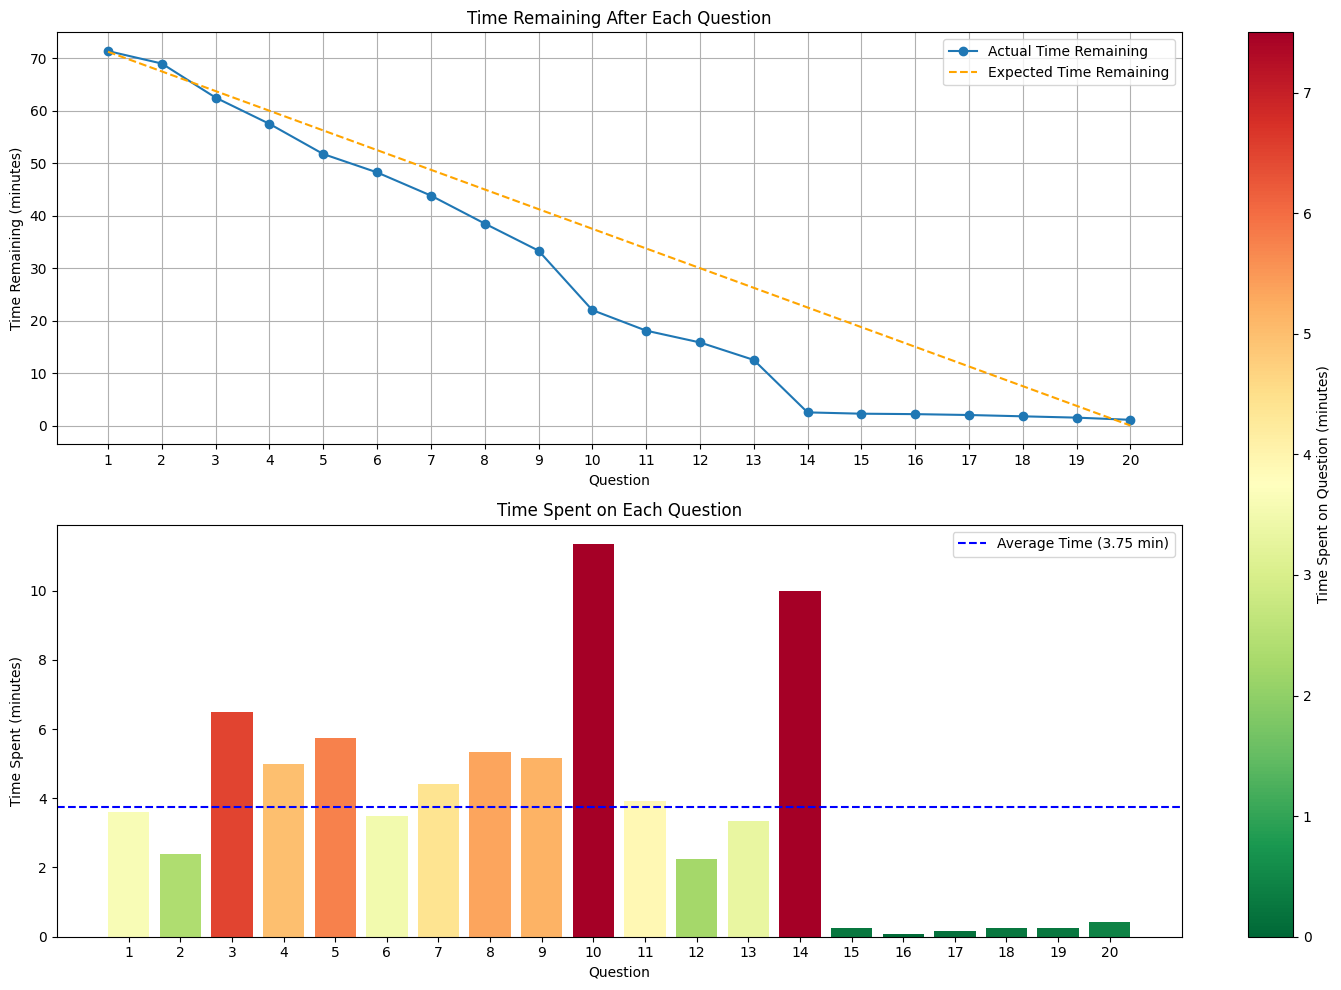

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import timedelta
import numpy as np
import matplotlib.colors as mcolors

# Function to parse timedelta
def parse_timedelta(time_str):
    h, m, s = map(int, time_str.split(':'))
    return timedelta(hours=h, minutes=m, seconds=s)

# Load the JSON file
file_path = 'time_analysis.json'
with open(file_path, 'r') as json_file:
    papers_list = json.load(json_file)

# List all available papers
paper_names = [paper['Paper Name'] for paper in papers_list]
print("Available papers:")
for i, name in enumerate(paper_names, 1):
    print(f"{i}. {name}")

# Ask the user which paper to display
paper_choice = int(input("Enter the number of the paper you want to display: ")) - 1
selected_paper = papers_list[paper_choice]

# Convert the selected paper dictionary back to a DataFrame
analysis_df = pd.DataFrame(selected_paper)

# Convert time columns from string to timedelta for plotting
analysis_df['Time Remaining'] = analysis_df['Time Remaining'].apply(parse_timedelta)
analysis_df['Time Spent'] = analysis_df['Time Spent'].apply(parse_timedelta)
analysis_df['Time Spent on Question'] = analysis_df['Time Spent on Question'].apply(parse_timedelta)

# Convert timedelta to total minutes for plotting
analysis_df['Time Remaining (m)'] = analysis_df['Time Remaining'].dt.total_seconds() / 60
analysis_df['Time Spent (m)'] = analysis_df['Time Spent'].dt.total_seconds() / 60
analysis_df['Time Spent on Question (m)'] = analysis_df['Time Spent on Question'].dt.total_seconds() / 60

# Calculate average time spent per question
total_time = int(analysis_df['Total Time'][0])  # total time in minutes
average_time_per_question = total_time / len(analysis_df["Question"])

# Calculate expected time remaining if each question took the average time
expected_time_remaining = [total_time - (i * (total_time / len(analysis_df))) for i in range(1,len(analysis_df)+1)]

# Normalize the time spent for color mapping
norm = plt.Normalize(0, 2 * average_time_per_question)  # assuming 2 * average as a reasonable upper limit
sm = plt.cm.ScalarMappable(cmap='RdYlGn_r', norm=norm)
sm.set_array([])

# Apply colors based on normalized values
colors = sm.to_rgba(analysis_df['Time Spent on Question (m)'])

# Plotting
plt.figure(figsize=(14, 10))

# Plot 1: Time Remaining after each question with Expected Diagonal Line
plt.subplot(2, 1, 1)
plt.plot(analysis_df['Question'], analysis_df['Time Remaining (m)'], marker='o', label='Actual Time Remaining')
plt.plot(analysis_df['Question'], expected_time_remaining, linestyle='--', color='orange', label='Expected Time Remaining')
plt.title('Time Remaining After Each Question')
plt.xlabel('Question')
plt.ylabel('Time Remaining (minutes)')
plt.xticks(analysis_df['Question'])  # Show all integers on the x-axis
plt.legend()
plt.grid(True)

# Plot 2: Time Spent on Each Question with Average Line and Color Gradient
plt.subplot(2, 1, 2)
bars = plt.bar(analysis_df['Question'], analysis_df['Time Spent on Question (m)'], color=colors)
plt.axhline(y=average_time_per_question, color='blue', linestyle='--', label=f'Average Time ({average_time_per_question:.2f} min)')
plt.title('Time Spent on Each Question')
plt.xlabel('Question')
plt.ylabel('Time Spent (minutes)')
plt.xticks(analysis_df['Question'])  # Show all integers on the x-axis
plt.legend()

plt.tight_layout()

# Add color bar to indicate the scale
cbar = plt.colorbar(sm, ax=plt.gcf().axes, orientation='vertical', fraction=.1)
cbar.set_label('Time Spent on Question (minutes)')

plt.show()